In [21]:
import os
import random
from PIL import Image
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
from sklearn.metrics import accuracy_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

In [22]:
# ---------------------
# IMPORTAR DATOS KAGGLE
# ---------------------
import kagglehub

# Descargamos datos
path = kagglehub.dataset_download("hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images")

print("Directorio a la carpeta:", path)

Directorio a la carpeta: /kaggle/input/melanoma-skin-cancer-dataset-of-10000-images


In [23]:
# -------------------
# CARGAMOS LOS DATOS
# -------------------

dataset_path = path

X = []
y = []

for subset in ['train', 'test']:
    subset_path = os.path.join(dataset_path, 'melanoma_cancer_dataset', subset)
    for label in ['benign', 'malignant']:
        label_path = os.path.join(subset_path, label)
        for filename in sorted(os.listdir(label_path)):
            if filename.endswith((".jpg", ".png")):
                img_path = os.path.join(label_path, filename)
                img = Image.open(img_path).convert('RGB')
                img = img.resize((224, 224))
                X.append(np.array(img))
                y.append(0 if label == 'benign' else 1)

X = np.array(X)
y = np.array(y)

# Antes de dividir, guarda algunas muestras para comparar luego si se respeta el orden
original_samples = [(X[i].shape, y[i]) for i in range(5)]  # Primeras 5 imágenes y etiquetas

#Para asegurarme de que se hace bien la division de train y test, uso el train_test_split de sklearn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Imágenes cargadas de TRAIN: {X_train.shape}")
print(f"Etiquetas cargadas de TRAIN: {y_train.shape}")
print(f"Imágenes cargadas de TEST: {X_test.shape}")
print(f"Etiquetas cargadas de TEST: {y_test.shape}")


Imágenes cargadas de TRAIN: (8484, 224, 224, 3)
Etiquetas cargadas de TRAIN: (8484,)
Imágenes cargadas de TEST: (2121, 224, 224, 3)
Etiquetas cargadas de TEST: (2121,)


In [24]:
# ----------------------------------------
# VERIFICACIÓN ORDEN DIVISION TRAIN Y TEST
# ----------------------------------------

# Verifica la posición exacta en train o test
print("\n--- Verificación de correspondencia con posiciones exactas ---")
for i, (img_shape, label) in enumerate(original_samples):
    pos_in_train = None
    pos_in_test = None

    # Busca en TRAIN
    for j in range(len(X_train)):
        if np.array_equal(X_train[j], X[i]):
            pos_in_train = j
            break

    # Busca en TEST
    for k in range(len(X_test)):
        if np.array_equal(X_test[k], X[i]):
            pos_in_test = k
            break

    print(f"\nMuestra original {i+1}:")
    print(f"  - Shape: {img_shape}, Label: {label}")

    if pos_in_train is not None:
        print(f"  - ✅ Está en TRAIN (posición {pos_in_train})")
    elif pos_in_test is not None:
        print(f"  - ✅ Está en TEST (posición {pos_in_test})")
    else:
        print("  - ❌ No encontrada (error inesperado)")


--- Verificación de correspondencia con posiciones exactas ---

Muestra original 1:
  - Shape: (224, 224, 3), Label: 0
  - ✅ Está en TEST (posición 1279)

Muestra original 2:
  - Shape: (224, 224, 3), Label: 0
  - ✅ Está en TRAIN (posición 6908)

Muestra original 3:
  - Shape: (224, 224, 3), Label: 0
  - ✅ Está en TRAIN (posición 3995)

Muestra original 4:
  - Shape: (224, 224, 3), Label: 0
  - ✅ Está en TEST (posición 318)

Muestra original 5:
  - Shape: (224, 224, 3), Label: 0
  - ✅ Está en TRAIN (posición 8091)


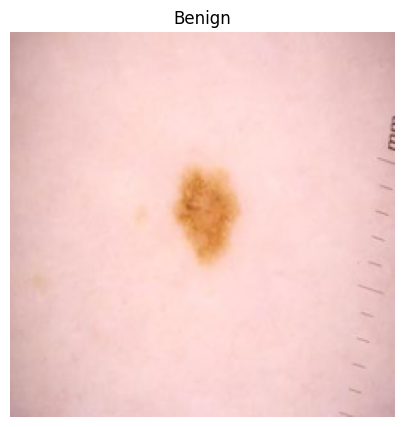

In [25]:
# ---------------------------
# PRINTEAMOS CUALQUIER IMAGEN
# ---------------------------
i = 1279

# Obtener la primera imagen y su etiqueta.
# BUSCAMOS EN TRAIN O TEST
first_image = X_test[i]
first_label = y_test[i]

# Crear una figura para mostrar la imagen
plt.figure(figsize=(5, 5))
plt.imshow(first_image)
plt.axis('off')

# Establecer el título como la etiqueta
label = 'Benign' if first_label == 0 else 'Malignant'
plt.title(label)

plt.show()




--- Estadísticas del Dataset ---
Total de imágenes: 10605
Número de imágenes benignas (0): 5500
Número de imágenes malignas (1): 5105

--- Distribución train/test ---
Imágenes TRAIN: (8484, 224, 224, 3) (80.0%)
Etiquetas TRAIN: (8484,)
Imágenes TEST: (2121, 224, 224, 3) (20.0%)
Etiquetas TEST: (2121,)

--- Visualización de muestras ---


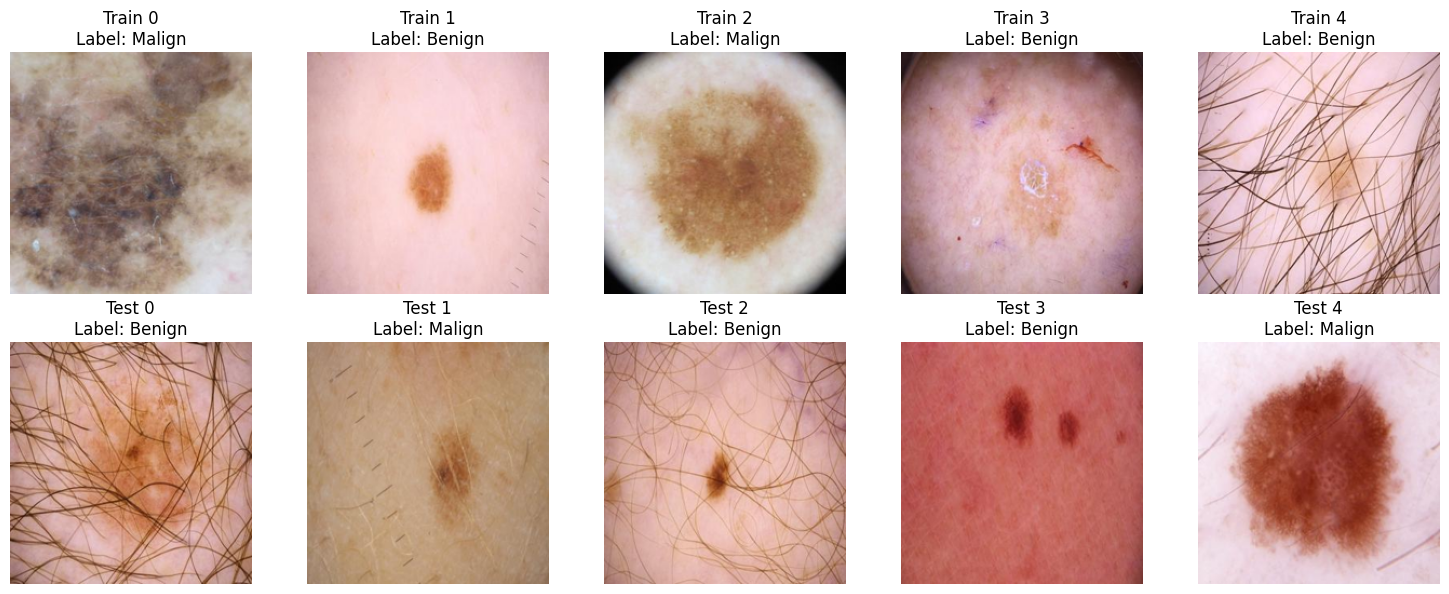

In [26]:
# ------------------------
# VERIFICACIÓN DEL DATASET
# ------------------------

print("\n--- Estadísticas del Dataset ---")
print(f"Total de imágenes: {len(X)}")
print(f"Número de imágenes benignas (0): {np.sum(y == 0)}")
print(f"Número de imágenes malignas (1): {np.sum(y == 1)}")


print("\n--- Distribución train/test ---")
print(f"Imágenes TRAIN: {X_train.shape} ({(len(X_train)/len(X))*100:.1f}%)")
print(f"Etiquetas TRAIN: {y_train.shape}")
print(f"Imágenes TEST: {X_test.shape} ({(len(X_test)/len(X))*100:.1f}%)")
print(f"Etiquetas TEST: {y_test.shape}")

# Visualización de las primeras 5 imágenes de train y test
print("\n--- Visualización de muestras ---")
plt.figure(figsize=(15, 6))

# 5 primeras de TRAIN
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[i])
    plt.title(f"Train {i}\nLabel: {'Benign' if y_train[i] == 0 else 'Malign'}")
    plt.axis('off')

# 5 primeras de TEST
for i in range(5):
    plt.subplot(2, 5, i+6)
    plt.imshow(X_test[i])
    plt.title(f"Test {i}\nLabel: {'Benign' if y_test[i] == 0 else 'Malign'}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [27]:
# ---------------------------
# Definimos el Dataset Custom
# ---------------------------

class ExactRotation:
    def __init__(self, angle):
        self.angle = angle

    def __call__(self, img):
        from torchvision.transforms.functional import rotate
        return rotate(img, self.angle)

train_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomChoice([
        ExactRotation(90),  # Rotación exacta de 90°
        ExactRotation(180),  # Rotación exacta de 180°
        ExactRotation(270),  # Rotación exacta de 270°
    ]),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         #std=[0.229, 0.224, 0.225]),
])


test_transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor(),
])

class SkinCancerDataset(Dataset):
    def __init__(self, X, y, transforms=None):
        super().__init__()
        self.X = X
        self.y = y
        self.transforms = transforms

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        image = self.X[idx]
        label = self.y[idx]

        if self.transforms:
            image = self.transforms(image)

        return image, label

In [33]:
# -----------------------------
## Creamos Dataset y DataLoader
# -----------------------------

# Creamos un dataset para train, otro para test y otro completo
train_dataset = SkinCancerDataset(X_train, y_train, transforms = train_transform)
test_dataset = SkinCancerDataset(X_test, y_test, transforms = test_transform)
dataset = SkinCancerDataset(X, y, transforms=train_transform)

# Creamos los dataloaders
train_loader = DataLoader(train_dataset,
                          batch_size=64, #Divide todas las imagenes en LOTES de 64
                          shuffle=True,
                          num_workers=1)

test_loader = DataLoader(test_dataset,
                         batch_size=64,
                         shuffle=False,
                         num_workers=1)

# Mensaje para ver cuantos lotes de batch hace
print("Nº lotes en train_loader: " , len(train_loader))
print("Nº lotes en test_loader: " , len(test_loader))

Nº lotes en train_loader:  133
Nº lotes en test_loader:  34


In [34]:
# ---------------------------------------------
# Configuramos el modelo, pérdida y optimizador
# ---------------------------------------------

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo preentrenado
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)  # Usar modelo preentrenado
#model = models.resnet18(weights=None)  # No usar modelo preentrenado
num_ftrs = model.fc.in_features  # Obtener el número de características de la última capa

model.fc = torch.nn.Sequential(
    torch.nn.Linear(num_ftrs, 512), # Capa de entrada: de 'num_ftrs' a 512 neuronas
    torch.nn.ReLU(),
    #torch.nn.Sigmoid(),
    #torch.nn.Tanh(),
    #torch.nn.Softmax(dim=1),
    torch.nn.Dropout(0.5), # 50% de las neuronas se "apagarán" aleatoriamente durante el entrenamiento.
    torch.nn.Linear(512, 2) # Capa de salida: de 512 a 2 neuronas (para clasificación binaria)
)

model = model.to(device)

# Definir la función de pérdida y el optimizador
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [35]:
# -------------------------------
# Función para entrenar por época
# -------------------------------

def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

In [36]:
# ------------------------------
# Función para evaluar el modelo
# ------------------------------

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = accuracy_score(all_labels, all_preds)

    return epoch_loss, epoch_acc

In [37]:
# --------------------------------------------
# FUNCION PARA HACER UN GRAFICO DE LOS ERRORES
# --------------------------------------------
def plot_training(train_accs, train_losses):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_accs, label='Train Accuracy')
    plt.title('Train Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', color='orange')
    plt.title('Train Loss over Epochs')
    plt.legend()

    plt.show()


Epoch 1/20:
Train Loss: 0.3105 | Train Acc: 86.63%
--------------------------------------------------
Epoch 2/20:
Train Loss: 0.2280 | Train Acc: 90.84%
--------------------------------------------------
Epoch 3/20:
Train Loss: 0.2113 | Train Acc: 91.41%
--------------------------------------------------
Epoch 4/20:
Train Loss: 0.2008 | Train Acc: 91.73%
--------------------------------------------------
Epoch 5/20:
Train Loss: 0.1861 | Train Acc: 92.49%
--------------------------------------------------
Epoch 6/20:
Train Loss: 0.1726 | Train Acc: 93.28%
--------------------------------------------------
Epoch 7/20:
Train Loss: 0.1686 | Train Acc: 92.99%
--------------------------------------------------
Epoch 8/20:
Train Loss: 0.1631 | Train Acc: 93.84%
--------------------------------------------------
Epoch 9/20:
Train Loss: 0.1569 | Train Acc: 93.72%
--------------------------------------------------
Epoch 10/20:
Train Loss: 0.1523 | Train Acc: 93.82%
------------------------------

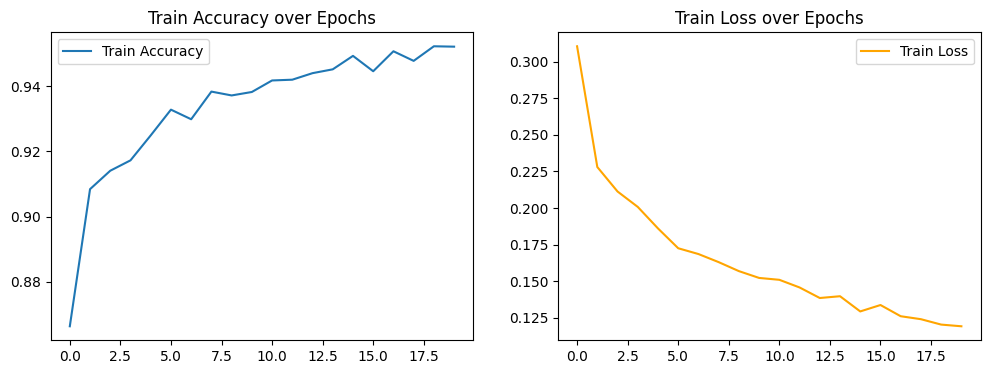

<All keys matched successfully>

In [38]:
# --------------------------
# Entrenamiento completo
# --------------------------
num_epochs = 20

# Variables para realizar el seguimiento del mejor modelo
best_loss = float('inf')
best_model_state = None

# Lista de errores
train_accs = []
train_losses = []

for epoch in range(num_epochs):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)

    train_accs.append(train_acc)
    train_losses.append(train_loss)

    print(f'Epoch {epoch+1}/{num_epochs}:')
    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%')
    print('-' * 50)

    # Guardar el modelo si mejora en entrenamiento (opcional)
    if train_loss < best_loss:
        best_loss = train_loss
        best_model_state = model.state_dict()


plot_training(train_accs, train_losses)

model.load_state_dict(best_model_state)


In [39]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test Final -> Loss: {test_loss:.4f}, Accuracy: {test_acc*100:.2f}%")

Test Final -> Loss: 0.2189, Accuracy: 91.65%


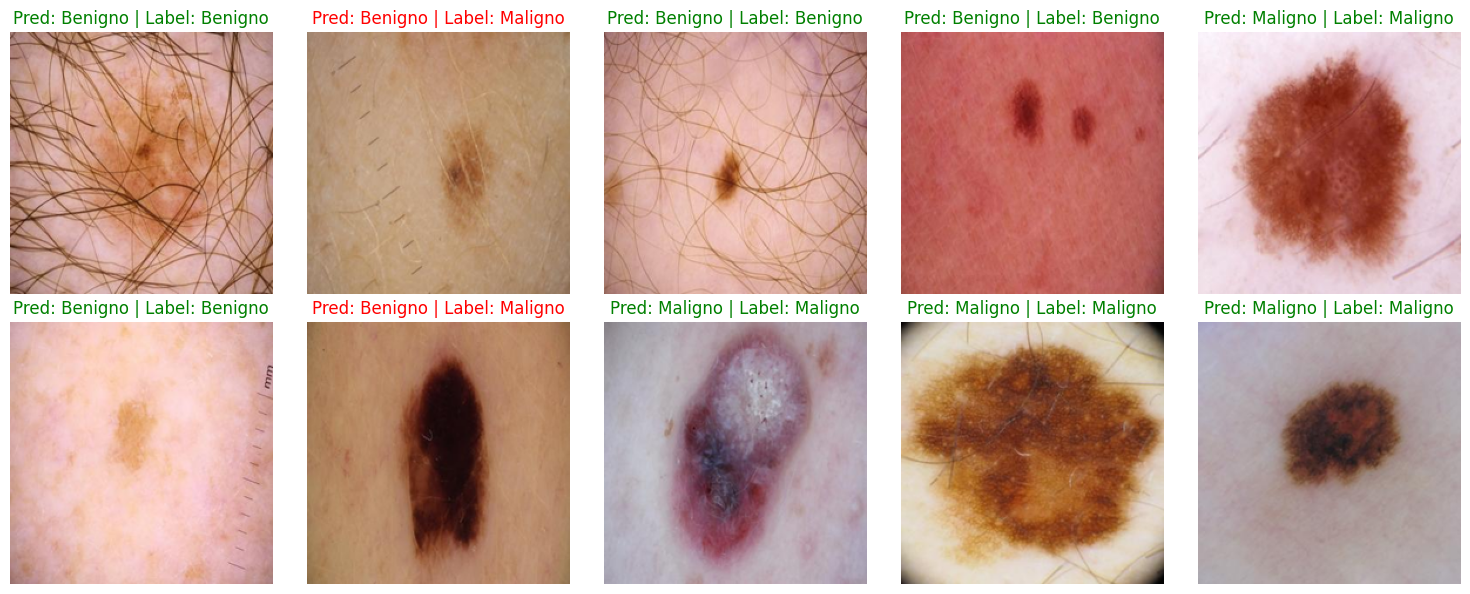

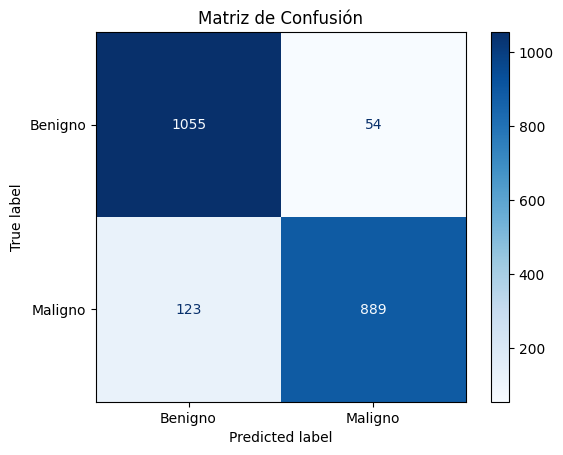

In [40]:
# ----------------------------
# Visualización de predicciones
# ----------------------------
model.eval()
num_images_to_show = 10
shown = 0

class_names = ["Benigno", "Maligno"]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        for i in range(images.size(0)):
            if shown >= num_images_to_show:
                break

            img = images[i].cpu().permute(1, 2, 0).numpy()
            true_label = class_names[labels[i].item()]
            pred_label = class_names[preds[i].item()]

            axes[shown].imshow(img)
            axes[shown].set_title(f"Pred: {pred_label} | Label: {true_label}",
                                  color='green' if pred_label == true_label else 'red')
            axes[shown].axis('off')
            shown += 1

        if shown >= num_images_to_show:
            break

plt.tight_layout()
plt.show()


# ----------------------------
# Matriz de confusión completa
# ----------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Benigno", "Maligno"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Matriz de Confusión")
plt.show()


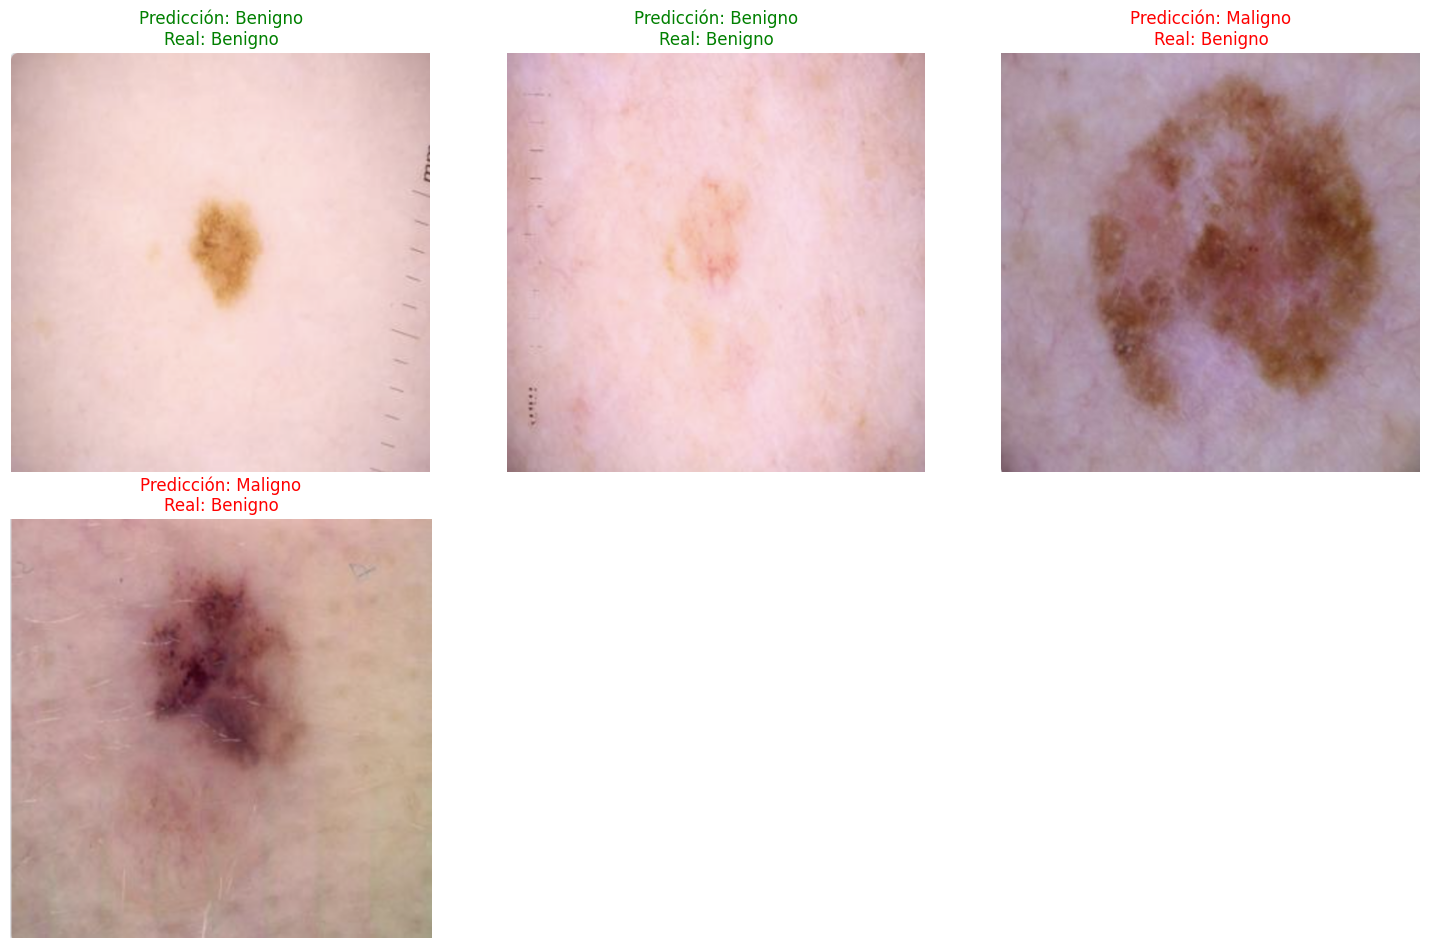

In [44]:
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])


# Lista de rutas de imágenes
image_paths = [
   '/content/BUENO.png',
   '/content/BUENO 1.png',
   '/content/MALO.png',
   '/content/MALO 1.png'
    # Añade las que quieras
]

# Cargar modelo
model.load_state_dict(best_model_state)
model = model.to(device)
model.eval()

# Número de columnas y filas en el grid
n_images = len(image_paths)
n_cols = 3
n_rows = (n_images + n_cols - 1) // n_cols

# Crear figura
plt.figure(figsize=(5 * n_cols, 5 * n_rows))

for idx, path in enumerate(image_paths):
    image = Image.open(path).convert("RGB")
    input_tensor = test_transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted_class = torch.max(output, 1)

    label = "Maligno" if predicted_class.item() == 1 else "Benigno"
    color = 'red' if label == "Maligno" else 'green'

    plt.subplot(n_rows, n_cols, idx + 1)
    plt.imshow(image)
    plt.title(
            f"Predicción: {'Maligno' if predicted_class == 1 else 'Benigno'}\n"
            f"Real: {'Maligno' if label == 1 else 'Benigno'}",
            color=color, fontsize=12
        )
    plt.axis("off")

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()
